In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import scipy
import ipywidgets as widgets
import bisect
from datetime import datetime

import pychaoson.calculate_chaos as calc_chaos
import pychaoson.chaotic_systems as chaotic_systems

# Plot Dimension Analysis Code

In [3]:
def plot_2d_heatmap(data, chaotic_system, dims, title):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(title)
    param_space = chaotic_system.get_param_space()
    param = param_space[dims[1]]
    ax.set_xticks([0, data.shape[0] - 1])
    ax.set_xticklabels([param[0], param[1]])
    ax.set_xlabel("Dim: {}".format(dims[1]))
    param = param_space[dims[0]]
    ax.set_yticks([0, data.shape[1] - 1])
    ax.set_yticklabels([param[0], param[1]])
    ax.set_ylabel("Dim: {}".format(dims[0]))
    ax.imshow(data, cmap='plasma', interpolation='nearest')
    plt.show()

def plot_1d_heatmap(data, chaotic_system, dims, title):
    param_space = chaotic_system.get_param_space()[dims[0]]
    x = np.linspace(param_space[0], param_space[1], data.shape[0])
    y = data
    fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)
    extent = [x[0] - (x[1] - x[0]) / 2., x[-1] + (x[1] - x[0]) / 2., 0, 1]
    ax.set_title(title)
    ax.imshow(y[np.newaxis, :], cmap="plasma", interpolation='nearest', aspect="auto", extent=extent)
    ax.set_yticks([])
    ax.set_xlim(extent[0], extent[1])
    ax2.plot(x, y)

    plt.tight_layout()
    plt.show()


def interactive_dimension_analysis(dimension_analysis_func, chaotic_system, plot_dims, slider_dims=None, points_per_dim=40,
                                    time_series_len=1000, take_last=100):
    def process_slider(**kwargs):
        box_count_dims_tmp = box_count_dims.copy()
        param_space = chaotic_system.get_param_space()
        # if kwargs are zero, this means that there are no slider available and the dimensions array has already the
        # correct dimensions to be displayed
        if kwargs is not None:
            # if there are sliders, the kwargs is a dict that contains the value for every slider. For every slider
            # dimension the corresponding value is fixed
            for i in range(len(slider_dims)):
                key = list(kwargs.keys())[i]
                param = param_space[slider_dims[i]]
                param_linspace = np.linspace(param[0], param[1], points_per_dim)
                idx = list(param_linspace).index(kwargs[key])
                box_count_dims_tmp = box_count_dims_tmp[idx]
        # plot
        plot_2d_heatmap(box_count_dims_tmp, chaotic_system, dims, points_per_dim, title)
        
    if slider_dims is None:
        slider_dims = []


    dims = slider_dims + plot_dims

    title = 'Dimension Anaylsis of system "{}" on Dim "{}"'.format(chaotic_system.get_name(),
                                                               ', '.join([str(dim) for dim in dims]))
    box_count_dims = dimension_analysis_func(chaotic_system, dims, points_per_dim, time_series_len, take_last)
    if len(dims) == 1:
        plot_1d_heatmap(box_count_dims, chaotic_system, dims, title)
    if len(dims) == 2:
        plot_2d_heatmap(box_count_dims, chaotic_system, dims, title)
    if len(dims) > 2:
        sliders = {}
        param_space = chaotic_system.get_param_space()
        for slider_dim in slider_dims:
            param = param_space[slider_dim]
            param_linspace = np.linspace(param[0], param[1], points_per_dim)
            sliders["Dim:" + str(slider_dim)] = widgets.SelectionSlider(options=list(param_linspace),
                                                                        description='Dim {} Slider:'.format(
                                                                            str(slider_dim)))
        ui = widgets.HBox(list(sliders.values()))
        out = widgets.interactive_output(process_slider, sliders)
        display(ui, out)


# Plot Bifurcation Analysis Code

In [4]:
def interactive_bifurcation_analysis(chaotic_system, plot_dim, slider_dims=None, points_per_dim=100,
                                    time_series_len=1000, take_last=100):
    if slider_dims is None:
            slider_dims = []
    dims = slider_dims + [plot_dim]

    # inner function reprints the plot in case a slider value changes
    def plot_bifurcation(**kwargs):
        # init plot values and copy time series array
        X = []
        Y = []
        dimensions_array_tmp = dimensions_array.copy()

        # if kwargs are zero, this means that there are no slider available and the dimensions array has already the
        # correct dimensions to be displayed
        if kwargs is not None:
            # if there are sliders, the kwargs is a dict that contains the value for every slider. For every slider
            # dimension the corresponding value is fixed
            for i in range(len(slider_dims)):
                key = list(kwargs.keys())[i]
                param = param_space[slider_dim]
                param_linspace = np.linspace(param[0], param[1], points_per_dim)
                idx = list(param_linspace).index(kwargs[key])
                dimensions_array_tmp = dimensions_array_tmp[idx]

        # fill the plot values with the points
        for param_idx in range(len(dimensions_array_tmp)):
            time_series = time_series_list[int(dimensions_array_tmp[param_idx])]
            X = X + [param_idx for i in range(len(time_series))]
            Y = Y + time_series
        # plot
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(X, Y, ',k', alpha=1.)
        ax.set_title(title)

    title = 'Bifurcation Diagram of {} on Dimension "{}"'.format(chaotic_system.get_name(), ', '.join(
        [str(dim) for dim in ([plot_dim] + slider_dims)]))  #

    dimensions_array, time_series_list = calc_chaos.bifurcation_analysis(chaotic_system, plot_dim, slider_dims,
                                                                         points_per_dim,
                                                                         time_series_len, take_last)

    # if only one dimension is given just plot once
    if len(slider_dims) == 0:
        plot_bifurcation()
    else:
        # else initialize and display widget sliders with the right values
        sliders = {}
        param_space = chaotic_system.get_param_space()
        for slider_dim in slider_dims:
            param = param_space[slider_dim]
            param_linspace = np.linspace(param[0], param[1], points_per_dim)
            step = param_linspace[1] - param_linspace[0]

            sliders["Dim:" + str(slider_dim)] = widgets.SelectionSlider(options=list(param_linspace),
                                                                        description='Dim {} Slider:'.format(
                                                                            str(slider_dim)))
        ui = widgets.HBox(list(sliders.values()))
        out = widgets.interactive_output(plot_bifurcation, sliders)
        display(ui, out)


# Plot Chaotic Systems
In order to find region where pattern create interesting sounds, it is useful to take a look at the parameter space and visualize the amount of chaos at a given location in this space.
There are various methods. The ones that are compared in this notebook:
- Dimension Analysis (Box Count Dimension, Correlation Dimension, ...)
- Bifurcation Diagrams
- Lyapunov Exponents

## Logistic Map
This is the most widely known Chaotic Map and is used in various fields such as in population growth of a species. It was chosen, because of its intuitive structure, 1D to 1D mapping and its popularity outside of chaos theory. 
#### Formula:
$x_{n+1} = rx_n (1 - x_n)$
#### Parameter Dimensions:
${r \in \mathbb{R}: 0 \leq r \leq 4 }$ 
#### Output Dimensions:  
${x \in \mathbb{R}: 0 \leq x \leq 1 }$

### Box Count Dimension (Take all)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 982.88it/s]


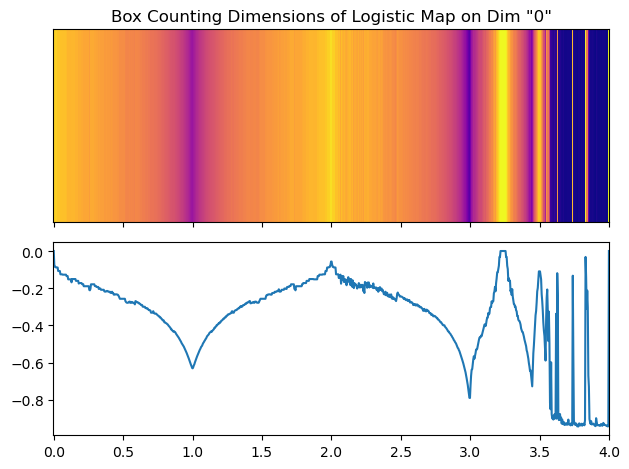

In [7]:
logistic_map = chaotic_systems.LogisticMap()
interactive_dimension_analysis(calc_chaos.box_count_dimension_analysis, logistic_map, [0], points_per_dim=1000, time_series_len=1000, take_last=1000)

### Box Count Dimension (Take last 100)

100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 28.94it/s]


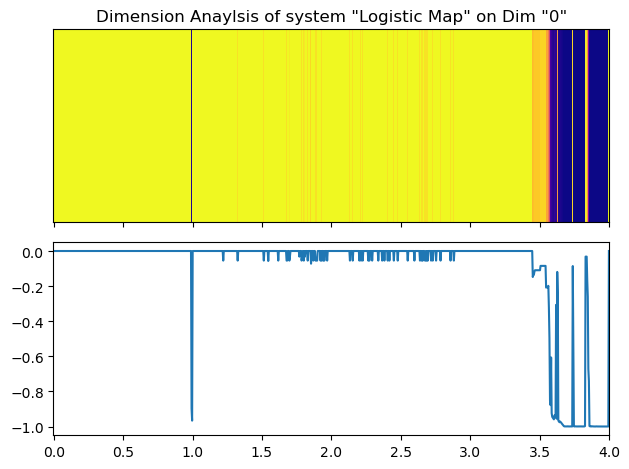

In [9]:
logistic_map = chaotic_systems.LogisticMap()
interactive_dimension_analysis(calc_chaos.box_count_dimension_analysis, logistic_map, [0], points_per_dim=1000, time_series_len=100000, take_last=10000)

### Sample Entropy:

100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 72.85it/s]


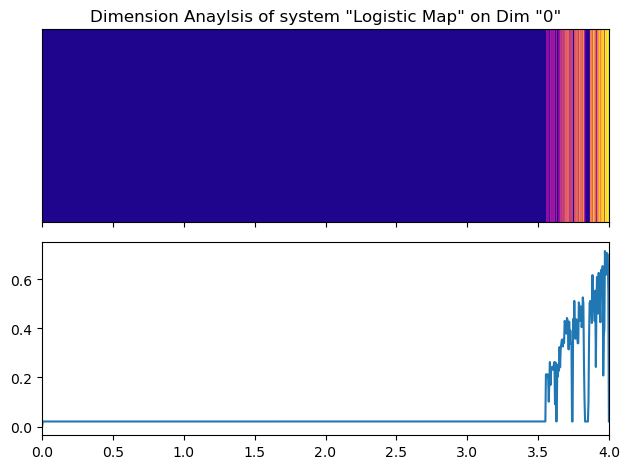

In [10]:
logistic_map = chaotic_systems.LogisticMap()
interactive_dimension_analysis(calc_chaos.sample_entropy_analysis, logistic_map, [0], points_per_dim=1000, time_series_len=1000)

### Bifucration(Take Last)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4374.48it/s]


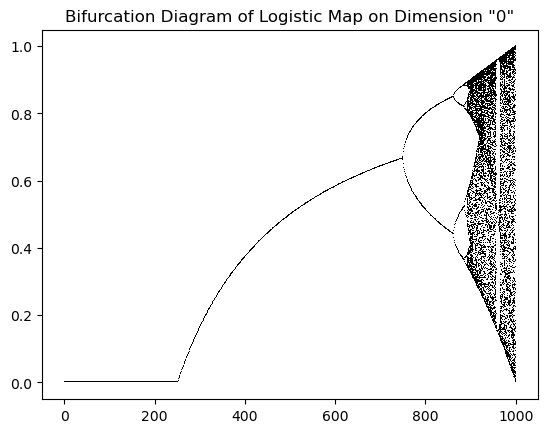

In [12]:
logistic_map = chaotic_systems.LogisticMap()
interactive_bifurcation_analysis(logistic_map, 0, [], points_per_dim=1000, time_series_len=1000, take_last=100)

### Bifucration(Take All)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3005.32it/s]


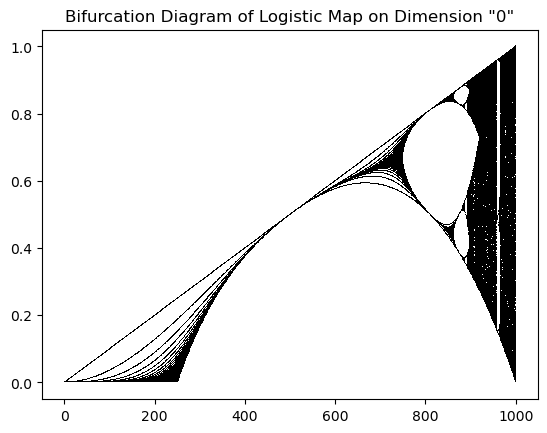

In [13]:
logistic_map = chaotic_systems.LogisticMap()
interactive_bifurcation_analysis(logistic_map, 0, [], points_per_dim=1000, time_series_len=1000, take_last=1000)

## Circle Map
This map is a specific version
#### Formula
$\theta_{i+1} = \theta_{i} + \Omega + \frac{K}{2\pi} sin(2\pi\theta_i)$
#### Parameter Dimensions:
${\Omega \in \mathbb{R}: 0 \leq \Omega \leq 1 }$ \
${K \in \mathbb{R}: 1 \leq K \leq 4 }$
#### Output Dimensions:  
${\theta \in \mathbb{R}: 0 \leq \theta \leq 1 }$ 

### Box Count Dmension (Take all)

100%|████████████████████████████████| 1000000/1000000 [34:06<00:00, 488.58it/s]


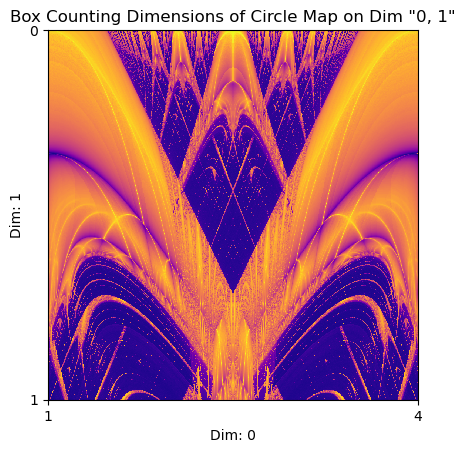

In [18]:
circle_map = chaotic_systems.CircleMap()
interactive_dimension_analysis(calc_chaos.box_count_dimension_analysis, circle_map, [0, 1], points_per_dim=1000, time_series_len=5000, take_last=5000)

### Box Count DImension (Take Last)

100%|████████████████████████████████████| 10000/10000 [01:17<00:00, 129.83it/s]


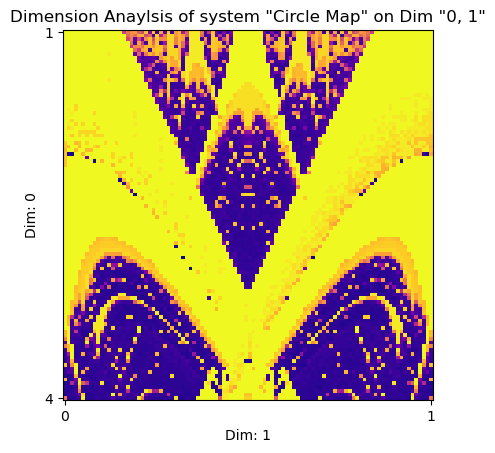

In [18]:
circle_map = chaotic_systems.CircleMap()
interactive_dimension_analysis(calc_chaos.box_count_dimension_analysis, circle_map, [0, 1], points_per_dim=100, time_series_len=5000, take_last=500)

### Sample Entropy

100%|█████████████████████████████████████| 10000/10000 [01:58<00:00, 84.20it/s]


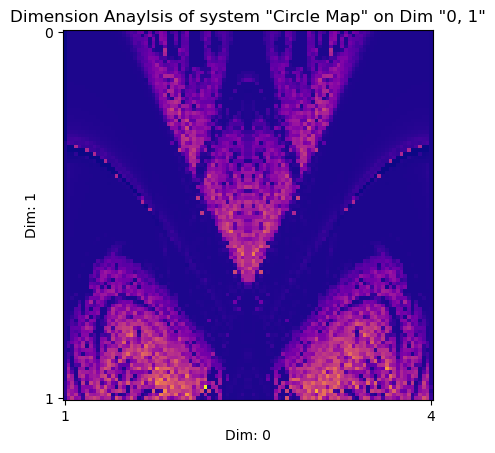

In [10]:
circle_map = chaotic_systems.CircleMap()
interactive_dimension_analysis(calc_chaos.sample_entropy_analysis, circle_map, [0, 1], points_per_dim=100, time_series_len=50)

### Bifurcation(Take Last)

In [1]:
circle_map = chaotic_systems.CircleMap()
interactive_bifurcation_analysis(circle_map, 1, [0], points_per_dim=300, time_series_len=1000, take_last=100)

NameError: name 'chaotic_systems' is not defined

### Bifurcation(Take All)

In [6]:
circle_map = chaotic_systems.CircleMap()
interactive_bifurcation_analysis(circle_map, 1, [0], points_per_dim=300, time_series_len=500, take_last=500)

100%|███████████████████████████████████| 90000/90000 [00:52<00:00, 1701.62it/s]


Output()

## Chialvo Map
This map is a specific version
#### Formula:
$x_{n+1} = x_n²exp(y_n - x_n) + k$ \
$y_{n+1} = ay_n - bx_n +c$
#### Parameter Dimensions:
${a \in \mathbb{R}: 0 \leq a \leq 1 }$ \
${b \in \mathbb{R}: 1 \leq b \leq 4 }$ \
${c \in \mathbb{R}: 0 \leq c \leq 1 }$ \
${k \in \mathbb{R}: 1 \leq k \leq 4 }$
#### Output Dimensions:  
${x \in \mathbb{R}: 0 \leq x \leq 1 }$ \
${y \in \mathbb{R}: 0 \leq y \leq 1 }$ \
$y$ can be omitted in some cases, because it often goes to 0 in specific configurations

In [ ]:
chialvo_amp = chaotic_systems.ChialvoMap()
interactive_dimension_analysis(calc_chaos.sample_entropy_analysis, chialvo_amp, [0, 1], [2], points_per_dim=20, time_series_len=1000)

In [ ]:
chialvo_amp = chaotic_systems.ChialvoMap()
interactive_dimension_analysis(calc_chaos.box_count_dimension_analysis, chialvo_amp, [0, 1], points_per_dim=1000, time_series_len=1000)

In [ ]:
chialvo_amp = chaotic_systems.ChialvoMap()
interactive_bifurcation_analysis(chialvo_amp, 0, [], points_per_dim=1000, time_series_len=1000, take_last=100)

# Results Discussion
Here all the analysis methods are listed and evaluated
### Lyapunov Exponents
This method is pretty accurate, but only easy computable if the derivation is given. There are some numeric approximations of the system (insert names) but they are hard to automate for a general case and take a while to compute
### Box Count Dimensions
The benefit is that is easy to compute even for higher dimensions and can be plotted as a 2D Heat Map. The problem is that this method does not take into consideration if at some point a equilibrium is found. This can be wittnessed in the Logistic Map at r=1. It only takes some time to reach a point where the. This is not exactly useful for this appication, because it should have somewhat stable orbits to create interesting sounds. 
Therefore as in bifuraction diagrams it is a good idea to throw the first points away.
### Sample Entropy
Takes a long time to compute
### Bifurcaton
Only one dimension display


# Sensitivity Calibration

100%|████████████████████████████████████| 40000/40000 [04:06<00:00, 162.30it/s]


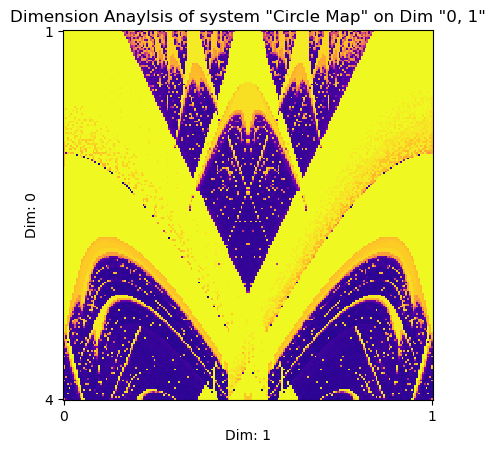

In [5]:
circle_map = chaotic_systems.CircleMap()
interactive_dimension_analysis(calc_chaos.box_count_dimension_analysis, circle_map, [0, 1], points_per_dim=200, time_series_len=5000, take_last=500)

100%|█████████████████████████████████████| 10000/10000 [03:19<00:00, 50.10it/s]


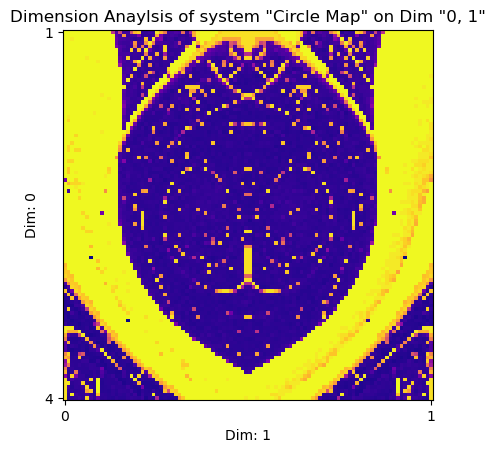

In [7]:
circle_map = chaotic_systems.CircleMap()
circle_map.add_poi([2.5,0.5], 0.9, 6)
interactive_dimension_analysis(calc_chaos.box_count_dimension_analysis, circle_map, [0, 1], points_per_dim=100, time_series_len=5000, take_last=500)

100%|████████████████████████████████████| 40000/40000 [04:02<00:00, 164.91it/s]


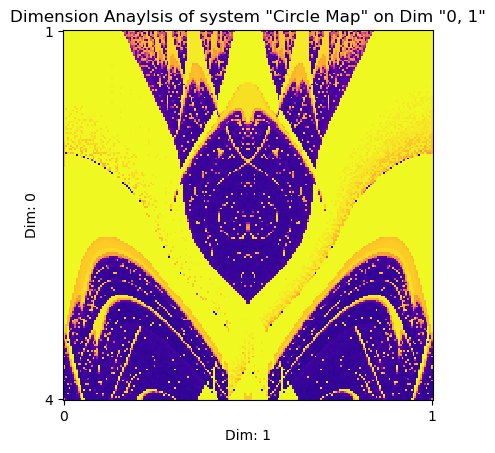

In [7]:
circle_map.remove_poi([2.5,0.5])
circle_map.add_poi([2.5,0.5], 0.3, 10)
interactive_dimension_analysis(calc_chaos.box_count_dimension_analysis, circle_map, [0, 1], points_per_dim=200, time_series_len=5000, take_last=500)

100%|████████████████████████████████████| 40000/40000 [05:12<00:00, 128.17it/s]


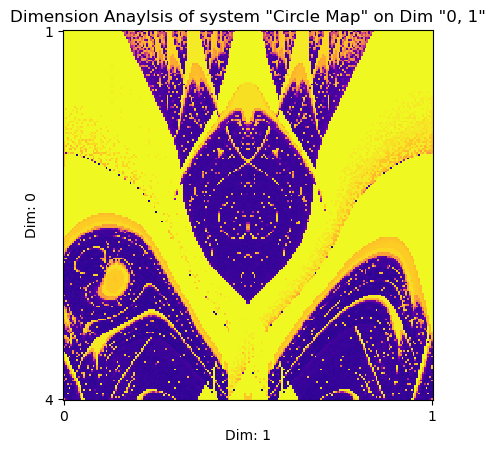

In [8]:
circle_map.add_poi([3,0.1], 0.3, 10)
interactive_dimension_analysis(calc_chaos.box_count_dimension_analysis, circle_map, [0, 1], points_per_dim=200, time_series_len=5000, take_last=500)

In [3]:
from sklearn.neighbors import KernelDensity
import numpy as np
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array([[0.2],[0.5]]))
kde.